In [ ]:
!pip install shap --quiet

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns


import shap
from google.colab import files



In [ ]:
def load_data():
    print("Faça upload dos arquivos: train.csv, validation.csv, test.csv")
    uploaded = files.upload()

    columns = [
        "age", "workclass", "fnlwgt", "education", "education_num", "marital_status",
        "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss",
        "hours_per_week", "native_country", "income"
    ]

    train = pd.read_csv('train.csv', header=None, names=columns)
    validation = pd.read_csv('validation.csv', header=None, names=columns)
    test = pd.read_csv('test.csv', header=None, names=columns)

    def remove_duplicate_header(df):
        return df[df['age'] != 'age'].reset_index(drop=True)

    train = remove_duplicate_header(train)
    validation = remove_duplicate_header(validation)
    test = remove_duplicate_header(test)

    return train, validation, test



In [ ]:
def preprocess_data(df, imputer=None, encoder=None, fit=False):
    # Remover espaços extras
    df = df.apply(lambda col: col.str.strip() if col.dtype == "object" else col)

    # Substituir '?' por NaN
    df.replace('?', np.nan, inplace=True)

    # Converter colunas numéricas para tipo correto
    numeric_cols_to_convert = ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
    for col in numeric_cols_to_convert:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Remover coluna fnlwgt
    if 'fnlwgt' in df.columns:
        df.drop(['fnlwgt'], axis=1, inplace=True)

    # Separar features e target
    X = df.drop('income', axis=1)
    y = df['income'].map({'<=50K': 0, '>50K': 1})

    # Remover linhas com target ausente
    valid_indices = y.notna()
    X = X[valid_indices]
    y = y[valid_indices].astype(int)

    # Identificar colunas categóricas e numéricas
    categorical_cols = X.select_dtypes(include=['object']).columns
    numerical_cols = X.select_dtypes(include=['number']).columns

    # Tratamento de categorias
    if fit:
        imputer = SimpleImputer(strategy='most_frequent')
        encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

        X_cat = imputer.fit_transform(X[categorical_cols])
        X_cat_encoded = encoder.fit_transform(X_cat)
    else:
        X_cat = imputer.transform(X[categorical_cols])
        X_cat_encoded = encoder.transform(X_cat)

    scaler = StandardScaler()
    X_num = scaler.fit_transform(X[numerical_cols])

    X_processed = np.hstack([X_cat_encoded, X_num])

    return X_processed, y, imputer, encoder, categorical_cols




In [ ]:
# Carregar dados
train, validation, test = load_data()


Faça upload dos arquivos: train.csv, validation.csv, test.csv


Saving test.csv to test (1).csv
Saving train.csv to train (1).csv
Saving validation.csv to validation (1).csv


In [ ]:
# Pré-processamento
imputer = SimpleImputer(strategy='most_frequent')
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

X_train, y_train, imputer, encoder, cat_cols = preprocess_data(train, imputer, encoder, fit=True)
X_val, y_val, _, _, _ = preprocess_data(validation, imputer, encoder, fit=False)
X_test, y_test, _, _, _ = preprocess_data(test, imputer, encoder, fit=False)


In [ ]:
# Modelo base
model = RandomForestClassifier(random_state=42)



In [ ]:
# Tunning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced', None]
}

grid_search = GridSearchCV(model, param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_






--- Validation ---
              precision    recall  f1-score   support

           0       0.91      0.88      0.90      5642
           1       0.65      0.72      0.68      1684

    accuracy                           0.85      7326
   macro avg       0.78      0.80      0.79      7326
weighted avg       0.85      0.85      0.85      7326

F1 Score: 0.6829954954954955


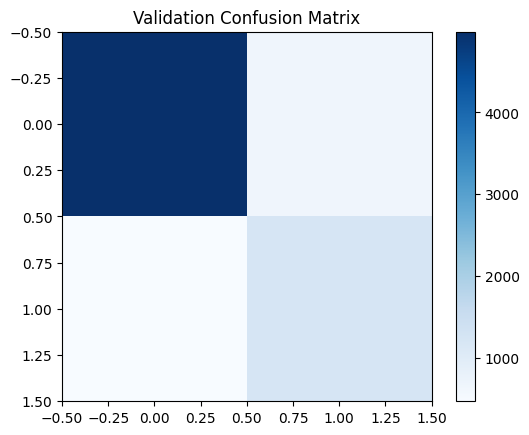


--- Test ---
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      5591
           1       0.66      0.71      0.69      1736

    accuracy                           0.84      7327
   macro avg       0.78      0.80      0.79      7327
weighted avg       0.85      0.84      0.85      7327

F1 Score: 0.6853030722391364


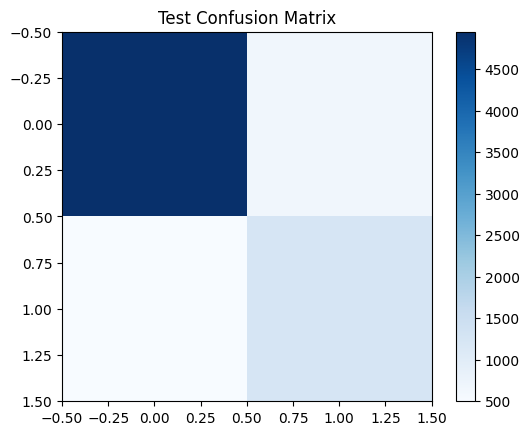

In [ ]:
def evaluate(model, X, y, name):
    y_pred = model.predict(X)
    print(f"\n--- {name} ---")
    print(classification_report(y, y_pred))
    print("F1 Score:", f1_score(y, y_pred))
    cm = confusion_matrix(y, y_pred)
    plt.figure()
    plt.imshow(cm, cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.colorbar()
    plt.show()

evaluate(best_model, X_val, y_val, "Validation")
evaluate(best_model, X_test, y_test, "Test")





<Figure size 640x480 with 0 Axes>

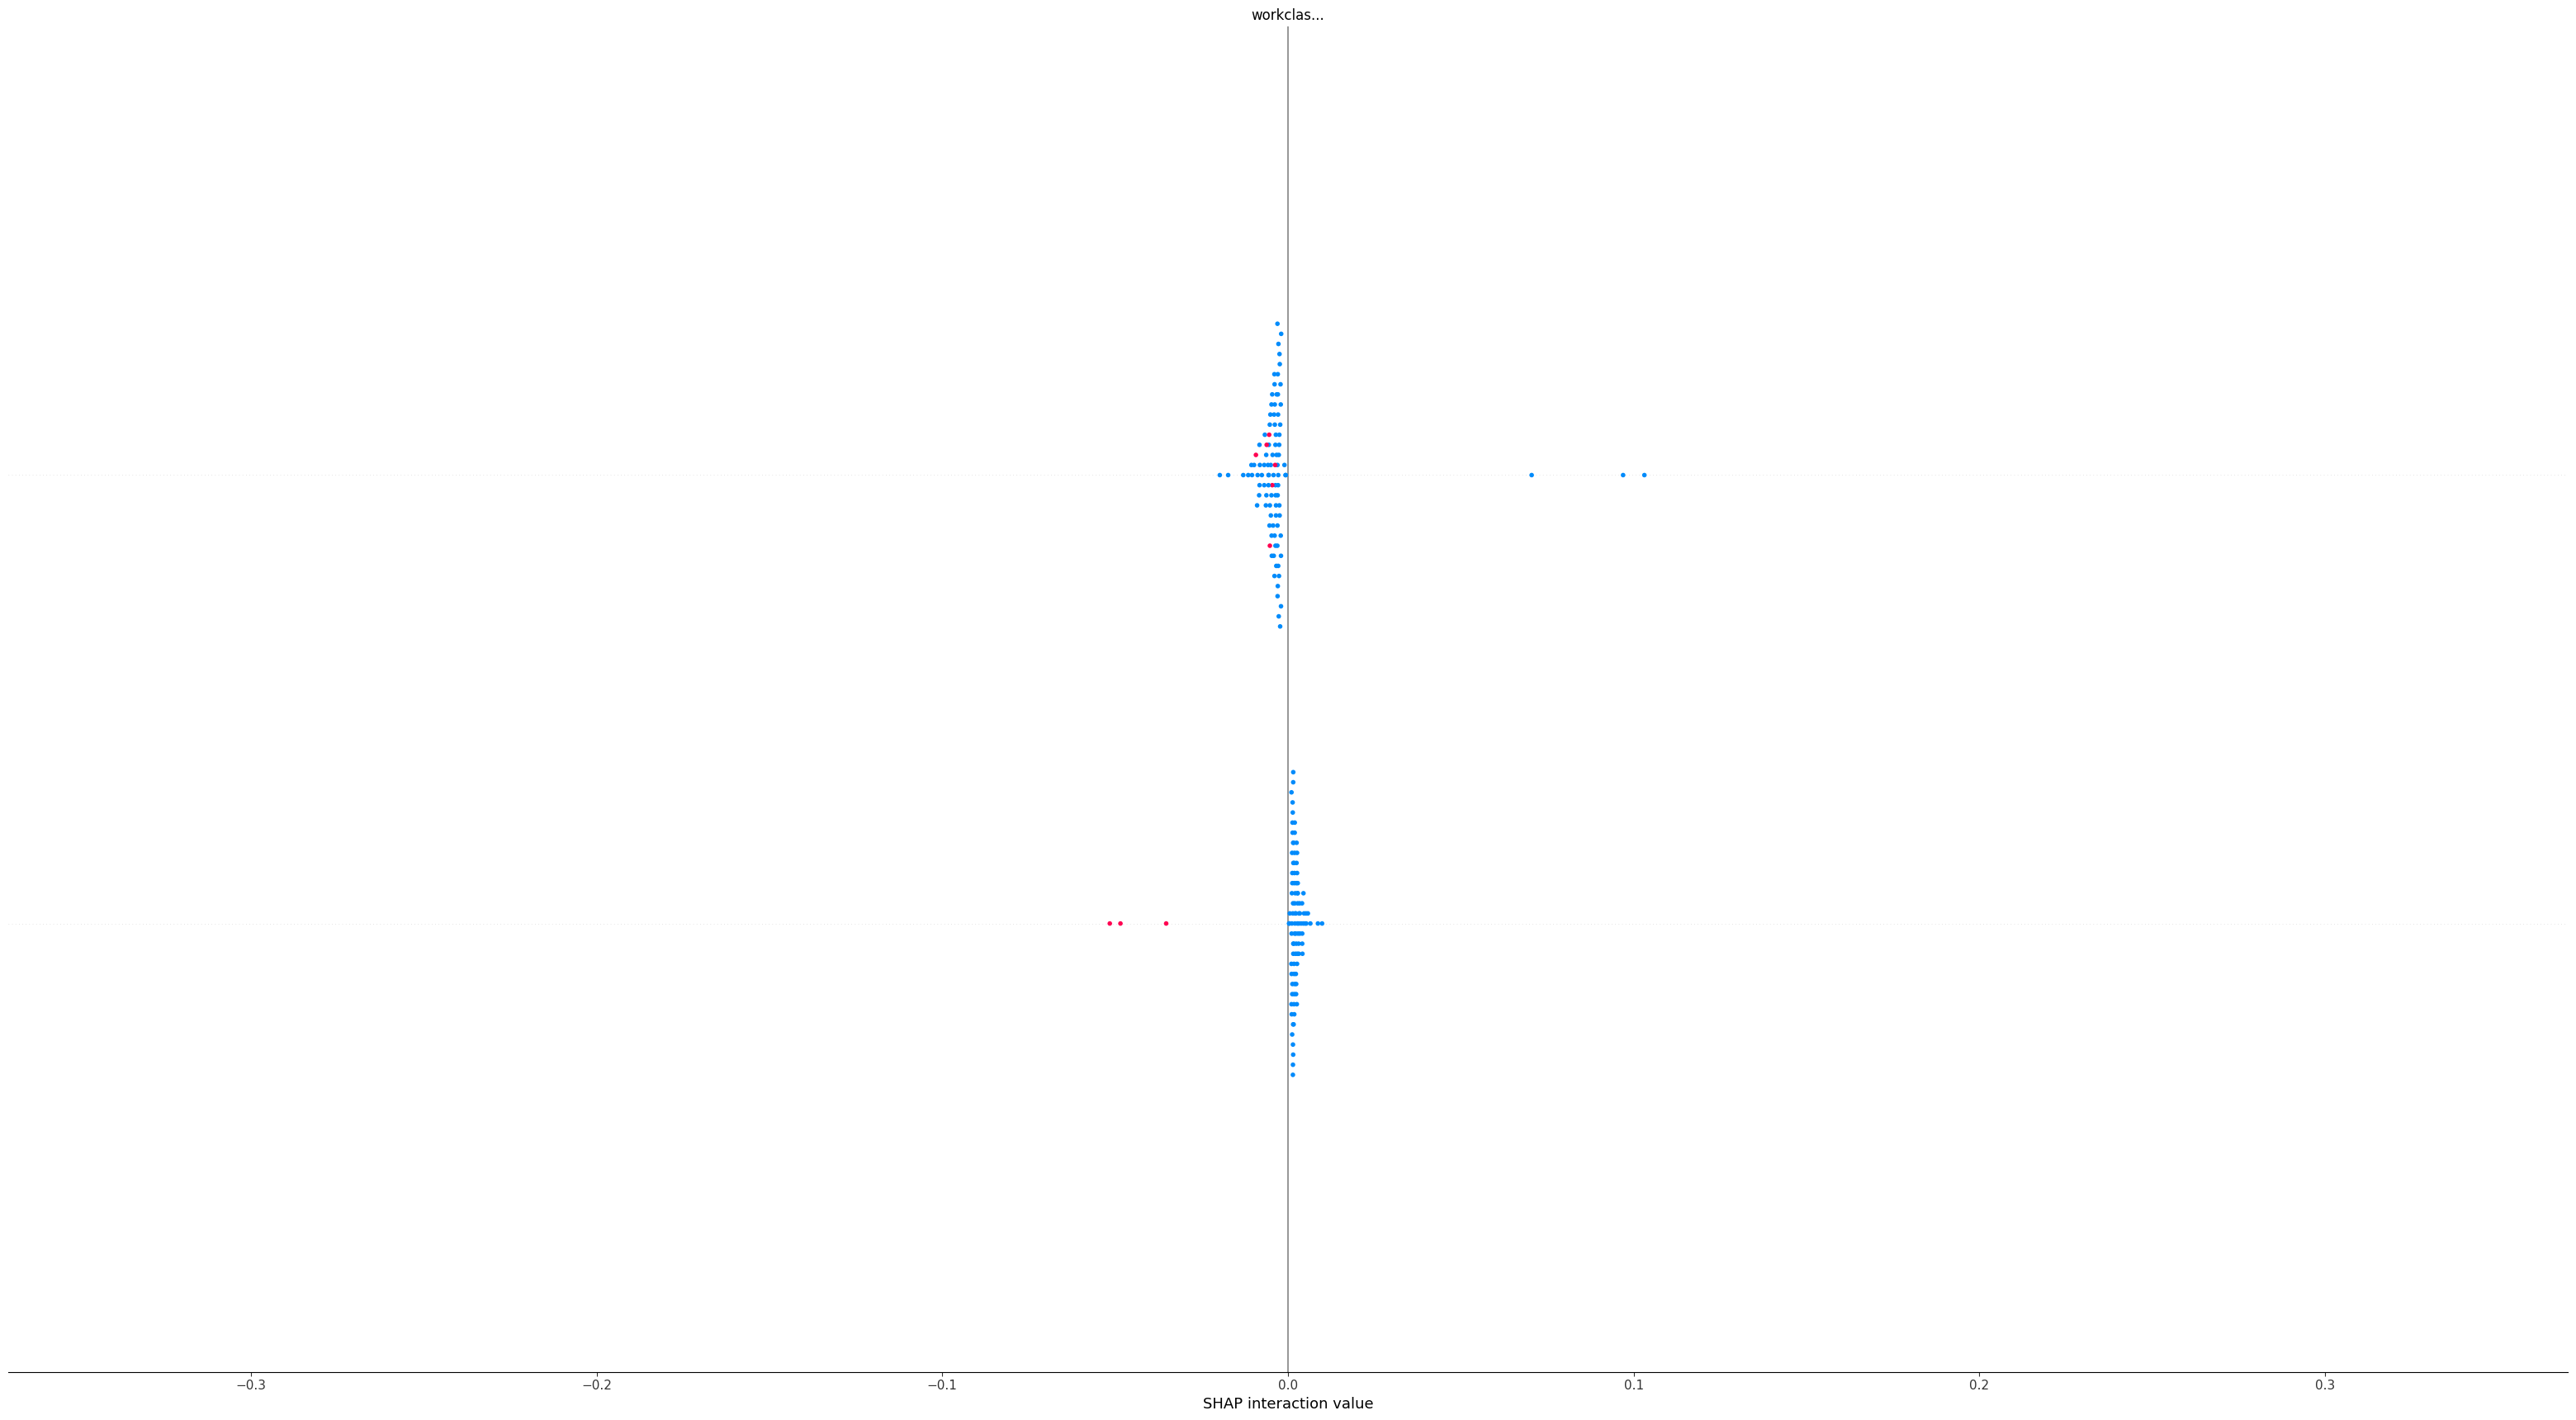

In [ ]:
def explain_model(model, X, feature_names):
    explainer = shap.TreeExplainer(model)
    X_sample = shap.utils.sample(X, 100)
    shap_values = explainer.shap_values(X_sample)
    shap.summary_plot(shap_values, X_sample, feature_names=feature_names, max_display=20)

feature_names = encoder.get_feature_names_out(input_features=cat_cols)
explain_model(best_model, X_test, feature_names)




In [ ]:
# Comparação antes e depois do tuning
baseline = RandomForestClassifier(random_state=42).fit(X_train, y_train)

results = {
    'Model': ['Baseline', 'Tuned'],
    'Validation F1': [
        f1_score(y_val, baseline.predict(X_val)),
        f1_score(y_val, best_model.predict(X_val))
    ],
    'Test F1': [
        f1_score(y_test, baseline.predict(X_test)),
        f1_score(y_test, best_model.predict(X_test))
    ]
}

print("\n📊 Resultados:")
print(pd.DataFrame(results).set_index('Model'))

print("\n🎯 Melhores parâmetros encontrados no GridSearch:")
print(grid_search.best_params_)



📊 Resultados:
          Validation F1   Test F1
Model                            
Baseline       0.653238  0.665455
Tuned          0.682995  0.685303

🎯 Melhores parâmetros encontrados no GridSearch:
{'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}


In [ ]:
results = {
    'Model': ['Baseline', 'Tuned'],
    'Validation F1': [
        f1_score(y_val, baseline.predict(X_val)),
        f1_score(y_val, best_model.predict(X_val))
    ],
    'Test F1': [
        f1_score(y_test, baseline.predict(X_test)),
        f1_score(y_test, best_model.predict(X_test))
    ]
}

df_results = pd.DataFrame(results).set_index('Model')

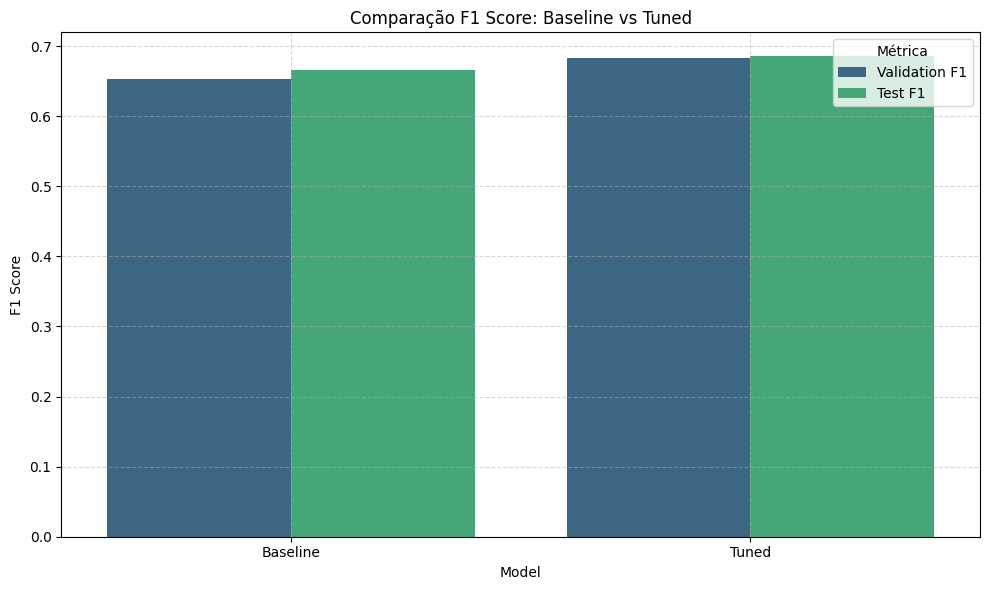

In [ ]:
# Preparando dados para plotagem
df_plot = df_results.reset_index()

# Transformando em formato longo para facilitar o plot
df_long = df_plot.melt(id_vars='Model', value_vars=['Validation F1', 'Test F1'],
                       var_name='Metric', value_name='F1 Score')

# Plotando
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='F1 Score', hue='Metric', data=df_long, palette="viridis")
plt.title('Comparação F1 Score: Baseline vs Tuned')
plt.ylabel('F1 Score')
plt.legend(title='Métrica')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()